https://www.kaggle.com/datasets/mohamedgobara/multi-class-knee-osteoporosis-x-ray-dataset \
https://www.kaggle.com/datasets/vuppalaadithyasairam/bone-fracture-detection-using-xrays \
https://www.kaggle.com/datasets/daverattan/dental-xrary-tfrecords \
https://www.kaggle.com/datasets/yovinyahathugoda/x-ray-body-part-dataset-512x512

### V2: outputs variable # of patches according to input

# Setup (No Attention Map)

In [33]:
import sys
sys.path.append("/Users/ms/cs/ML/SingleImageINR/MedDINOv3/nnUNet")

from nnunetv2.training.nnUNetTrainer.dinov3.dinov3.models.vision_transformer import vit_base

# import nnunetv2.training.nnUNetTrainer.dinov3.dinov3.models.vision_transformer
# from nnunetv2.training.nnUNetTrainer.dinov3.dinov3.models.vision_transformer import vit_base

In [34]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
from torchvision import transforms

# --- Device ---
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print("Using device:", device)

Using device: cuda


In [35]:
# --- Initialize the ViT backbone ---
model = vit_base(
    drop_path_rate=0.0,
    layerscale_init=1.0e-05,
    n_storage_tokens=4,
    qkv_bias=False,
    mask_k_bias=True,
    pos_embed_rope_dtype="fp32",
    norm_layer="layernormbf16",    
)

# --- Load MedDINOv3 pretrained weights ---
chkpt = torch.load("/home/minsukc/SIO/meddino_model.pth", map_location="cpu")

# If the checkpoint dict contains nested keys, extract the "teacher" weights if needed
if "teacher" in chkpt:
    chkpt = chkpt["teacher"]

model.load_state_dict(chkpt, strict=False)
model.to(device).eval()

print("✅ MedDINOv3 loaded successfully.")

/tmp/ipykernel_917935/3040867919.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  chkpt = torch.load("/home/minsukc/SIO/meddino_model.pth", map_location="cpu")


✅ MedDINOv3 loaded successfully.


In [36]:
# --- Image setup ---
data_dir = "/home/minsukc/SIO/data/"
# target_image = "ct_chest_1.jpeg"
# target_image = "ct_abdomen_2.png"  
# target_image = "ct_bone_1.jpg"  
target_image = "Chest_CT_2.png"  
img_path = os.path.join(data_dir, target_image)

# --- Preprocessing ---
preprocess = transforms.Compose([
    transforms.Resize((768, 768)),  # larger input for dense patch grid
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

image = Image.open(img_path).convert("RGB")
inputs = preprocess(image).unsqueeze(0).to(device)  # type: ignore # shape [1, 3, 768, 768]

In [37]:
# Author's code does not store the raw attention weights → hard to do CLS visualization

In [38]:
with torch.no_grad():
    feats = model.forward_features(inputs)

patch_feats = feats["x_norm_patchtokens"].squeeze(0)  # type: ignore # [N_patches, D]
cls_feat = feats["x_norm_clstoken"].unsqueeze(0)      # type: ignore # [1, D]

print("patch_feats:", patch_feats.shape)
print("cls_feat:", cls_feat.shape)

patch_feats: torch.Size([2304, 768])
cls_feat: torch.Size([1, 1, 768])


# Patch Similarity Map

In [39]:
num_patches = patch_feats.shape[0]
patch_side = int(num_patches ** 0.5)

# pick a few query patches (grid positions)
grid_size = 4
coords = np.linspace(0, patch_side - 1, grid_size, dtype=int)
query_indices = [y * patch_side + x for y in coords for x in coords]

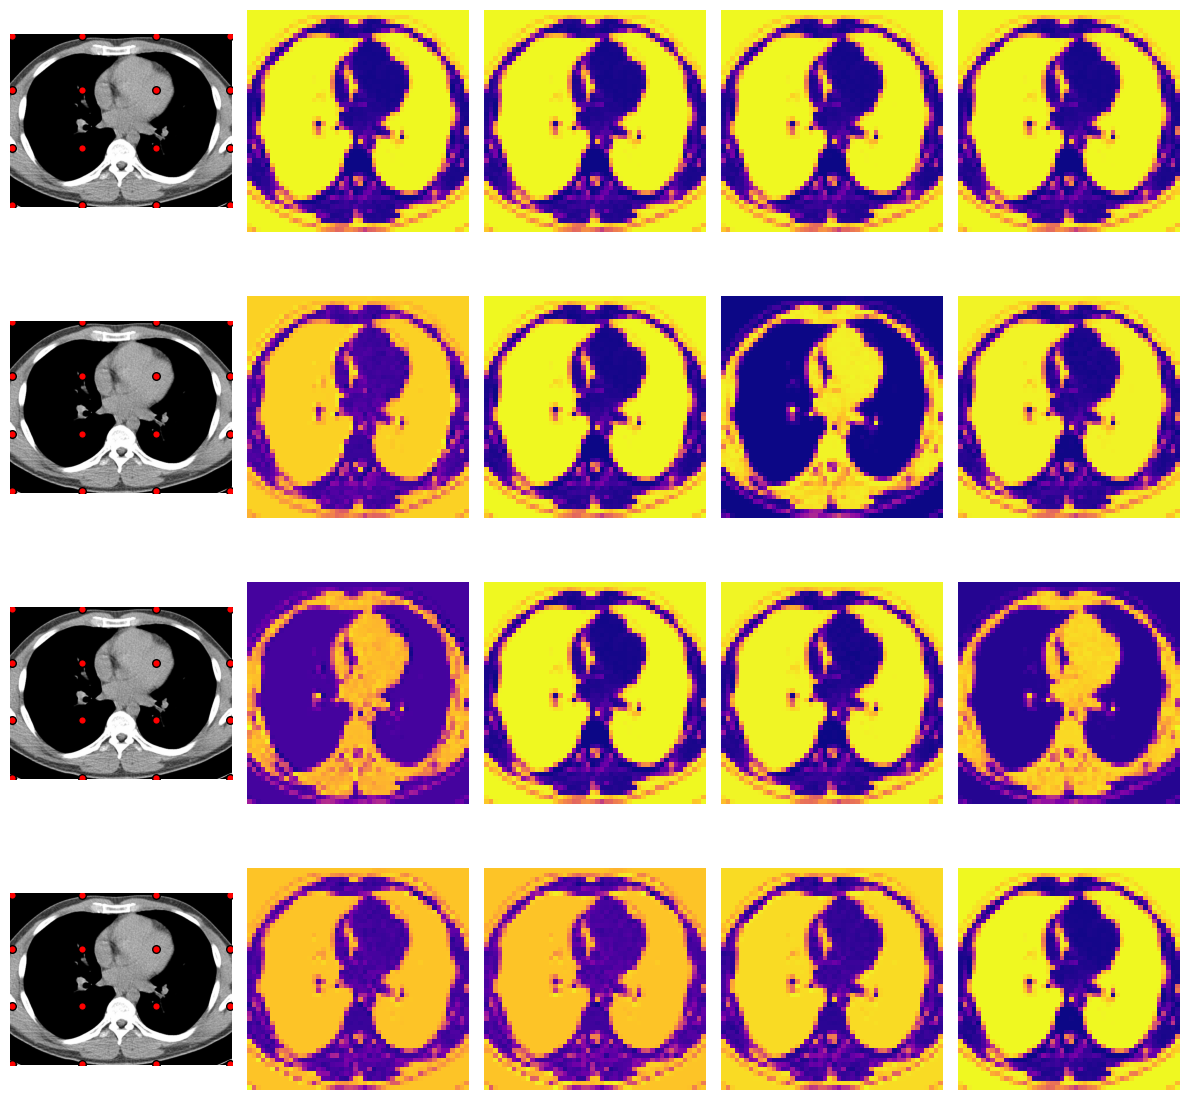

In [64]:
fig, axes = plt.subplots(grid_size, grid_size + 1, figsize=(12, 12))

# Left column: original image with red markers
for r in range(grid_size):
    ax = axes[r, 0]
    ax.imshow(image)
    ax.axis("off")
    for idx in query_indices:
        y, x = divmod(idx, patch_side)
        ax.scatter(
            (x + 0.5) * (image.width / patch_side),
            (y + 0.5) * (image.height / patch_side),
            color="red", s=30, edgecolors="black"
        )

# Right columns: similarity maps
for r in range(grid_size):
    for c in range(grid_size):
        idx = query_indices[r * grid_size + c]
        query_feat = patch_feats[idx:idx+1]
        sim = torch.nn.functional.cosine_similarity(query_feat, patch_feats)
        sim = sim.reshape(patch_side, patch_side).cpu().numpy()
        sim = (sim - sim.min()) / (sim.max() - sim.min() + 1e-8)
        ax = axes[r, c + 1]
        ax.imshow(sim, cmap="plasma", interpolation="nearest", vmin=0, vmax=1)
        ax.axis("off")

plt.tight_layout()
plt.show()

# PCA

In [65]:
from sklearn.decomposition import PCA

feats = patch_feats.cpu().numpy()
pca = PCA(n_components=3)
pca_feats = pca.fit_transform(feats)
pca_feats = (pca_feats - pca_feats.min(0)) / (pca_feats.max(0) - pca_feats.min(0) + 1e-8)

patch_h = patch_w = int(np.sqrt(len(pca_feats)))
pca_img = pca_feats.reshape(patch_h, patch_w, 3)

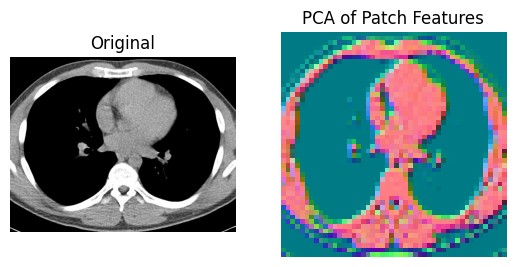

: 

In [ ]:
plt.subplot(1,2,1)
plt.imshow(image)
plt.axis("off")
plt.title("Original")

plt.subplot(1,2,2)
plt.imshow(pca_img, interpolation="nearest")
plt.axis("off")
plt.title("PCA of Patch Features")
plt.show()